In [2]:
import glob
import nibabel as nib
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map
import numpy as np
import os
import pandas as pd
import pickle
import re

In [3]:
subnum = '01'

data_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level1/'
out_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/derivatives/nilearn/glm/level2/'



In [9]:
if not os.path.exists(out_path):
    os.makedirs(out_path)

contrasts_path = os.path.join(out_path,"sub-%s/contrasts"%(subnum))
if not os.path.exists(contrasts_path):
    os.makedirs(contrasts_path)

In [16]:
in_path = os.path.join(data_path, 'sub-%s/contrasts'%(subnum))
sub_contrasts = os.listdir(in_path)
sub_contrasts.sort()

In [18]:
contrasts = ['cross', 'crossRt', 'fractalProb', 'fractalProbParam', 'stim', 'stimRt', 'valDiff', 'choiceLeft', 'conflict', 'noconflict', 'reward', 'rewardParam', 'rpe', 'task_on']

In [42]:
for c in contrasts:
    second_level_input = [os.path.join(in_path,x) for x in sub_contrasts if c+'.nii.gz' in x]
    design_matrix = pd.DataFrame([1] * len(second_level_input), columns=['intercept'])
    model = SecondLevelModel(smoothing_fwhm=5.0)

    c = re.sub("\.","",c)

    if len(second_level_input)>1:
        print("***********************************************")
        print("Running GLM for sub-%s contrast %s"%(subnum, c))
        print("***********************************************")
        model = model.fit(second_level_input, design_matrix=design_matrix)

        print("***********************************************")
        print("Saving GLM for sub-%s contrast %s"%(subnum, c))
        print("***********************************************")
        f = open('%s/sub-%s_%s_level2_glm.pkl' %(out_path,subnum, c), 'wb')
        pickle.dump(model, f)
        f.close()

        print("***********************************************")
        print("Running contrasts for sub-%s contrast %s"%(subnum, c))
        print("***********************************************")
        z_map = model.compute_contrast(output_type='z_score')

        nib.save(z_map, '%s/sub-%s_%s.nii.gz'%(contrasts_path, subnum, c))
        print("***********************************************")
        print("Done saving contrasts for sub-%s contrast %s"%(subnum, c))
        print("***********************************************")
        
    elif len(second_level_input) == 1:
        print("***********************************************")
        print("1 level 1 image found for sub-%s contrast %s"%(subnum, c))
        print("Skipping level 2 for sub-%s contrast %s"%(subnum, c))
        print("Saving level 1 for level 2 for sub-%s contrast %s"%(subnum, c))
        z_map = nib.load(second_level_input[0])
        nib.save(z_map, '%s/sub-%s_%s.nii.gz'%(contrasts_path, subnum, c))
        print("***********************************************")
    else:
        print("***********************************************")
        print("No level 1 image found for sub-%s contrast %s"%(subnum, c))
        print("***********************************************")

***********************************************
Running GLM for sub-01 contrast cross
***********************************************
***********************************************
Saving GLM for sub-01 contrast cross
***********************************************
***********************************************
Running contrasts for sub-01 contrast cross
***********************************************
***********************************************
Done saving contrasts for sub-01 contrast cross
***********************************************
***********************************************
Running GLM for sub-01 contrast crossRt
***********************************************
***********************************************
Saving GLM for sub-01 contrast crossRt
***********************************************
***********************************************
Running contrasts for sub-01 contrast crossRt
***********************************************
************************************

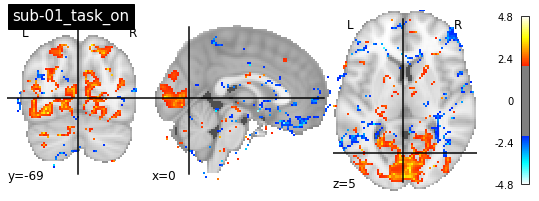

In [45]:
plot_stat_map(z_map, threshold=2.0, title='sub-%s_%s' % (subnum, c))